### Importing libraries

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm

### Importing dataset

In [200]:
path = '/Users/maryrosejofelvillacampa/Desktop/datasets/exoplanets.csv'
df = pd.read_csv(path)
df = pd.DataFrame(df)

df = df[["pl_orbsmax", "pl_orbeccen", "st_mass", "st_teff", "pl_orbper"]]
df.columns =["semi-major axis", "eccentricity", "stellar mass", "stellar temperature", "orbital period"]
df.dropna(subset=["eccentricity"], inplace=True)
df

,semi-major axis,eccentricity,stellar mass,stellar temperature,orbital period
0,1.290000,0.23100,2.70,4742.0,326.030000
1,1.540000,0.08000,1.80,4340.0,516.220000
2,0.830000,0.00000,2.20,4813.0,185.840000
3,2.770000,0.36900,0.90,5311.0,1773.400000
4,1.681000,0.68100,0.99,5674.0,798.500000
...,...,...,...,...,...
3367,0.059222,0.02150,1.30,NaN,4.617033
3368,0.827774,0.25960,1.30,NaN,241.258000
3369,2.513290,0.29870,1.30,NaN,1276.460000
3370,5.245580,0.00536,1.30,NaN,3848.860000


### Dataset exploration

In [201]:
shape = df.shape
print(f"The dataset has a dimension of {shape[0]} rows and {shape[1]} columns.")

nulls = df.isnull().sum()
print("\nThe number of missing values per variable:")
print(nulls)

The dataset has a dimension of 974 rows and 5 columns.

The number of missing values per variable:
semi-major axis        53
eccentricity            0
stellar mass           41
stellar temperature    93
orbital period          0
dtype: int64


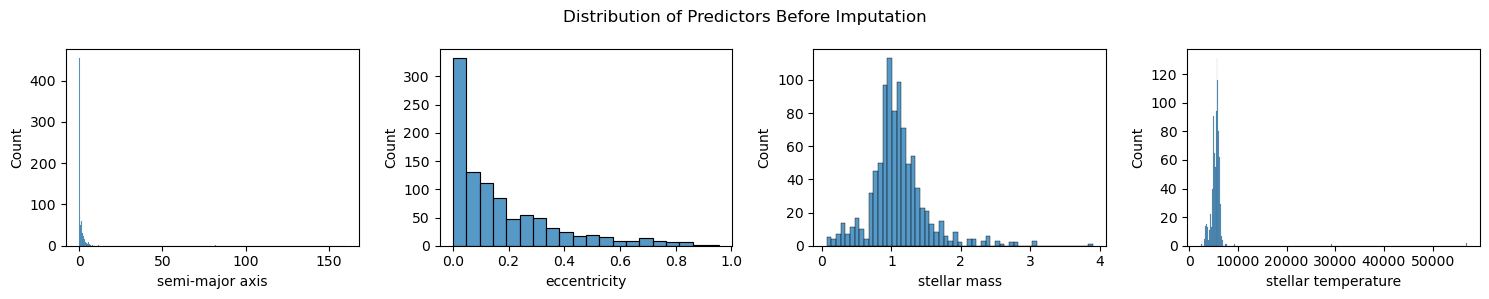

In [202]:
plt.figure(figsize=(15, 3))

plt.subplot(1,4,1)
sns.histplot(x=df["semi-major axis"])

plt.subplot(1,4,2)
sns.histplot(x=df["eccentricity"])

plt.subplot(1,4,3)
sns.histplot(x=df["stellar mass"])

plt.subplot(1,4,4)
sns.histplot(x=df["stellar temperature"])

plt.suptitle("Distribution of Predictors Before Imputation")
plt.tight_layout()
plt.show()

### Data cleaning

In [203]:
med_sma = df["semi-major axis"].median()
df["semi-major axis"] = df["semi-major axis"].fillna(med_sma)

med_sm = df["stellar mass"].median()
df["stellar mass"] = df["stellar mass"].fillna(med_sm)

med_st = df["stellar temperature"].median()
df["stellar temperature"] = df["stellar temperature"].fillna(med_st)

nulls = df.isnull().sum()
print("\nThe number of missing values per variable:")
print(nulls)


The number of missing values per variable:
semi-major axis        0
eccentricity           0
stellar mass           0
stellar temperature    0
orbital period         0
dtype: int64


In [204]:
print(df["orbital period"].min())
print(df["orbital period"].max())

0.09070629
555530.0


In [205]:
def cat_op(x):
    if 0 < x < 11:
        return "short"
    elif 11 <= x < 101:
        return "medium"
    elif x >= 101:
        return "long"

df["orbital period"] = df["orbital period"].apply(cat_op)
df["orbital period"].unique()

array(['long', 'short', 'medium'], dtype=object)

### Checking assumptions

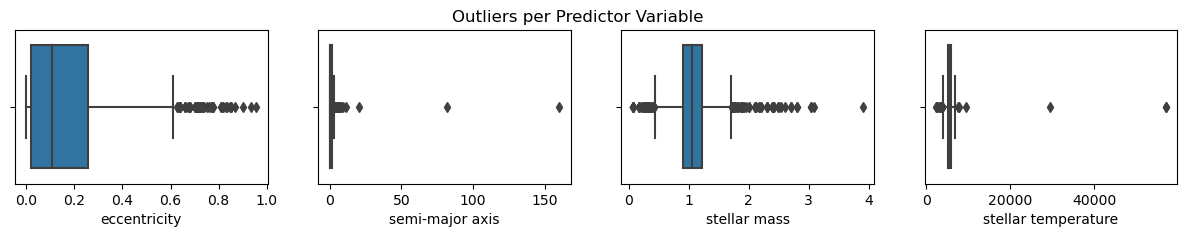

In [ ]:
#visualizing outliers per predictor
plt.figure(figsize=(15,2))

plt.subplot(1, 4, 1)
sns.boxplot(x=df["eccentricity"])

plt.subplot(1, 4, 2)
sns.boxplot(x=df["semi-major axis"])

plt.subplot(1,4,3)
sns.boxplot(x=df["stellar mass"])

plt.subplot(1,4,4)
sns.boxplot(x=df["stellar temperature"])

plt.suptitle("Outliers per Predictor Variable")
plt.show()

In [207]:
#checking correlation values between predictors to assess multicollinearity
df_predictors = df[["semi-major axis", "eccentricity", "stellar mass", "stellar temperature"]]
df_predictors.corr()

,semi-major axis,eccentricity,stellar mass,stellar temperature
semi-major axis,1.000000,0.195680,0.129501,0.046027
eccentricity,0.195680,1.000000,0.028581,-0.003143
stellar mass,0.129501,0.028581,1.000000,0.013126
stellar temperature,0.046027,-0.003143,0.013126,1.000000


In [208]:
#performing Variance Inflation Factor to assess multicollinearity
#optional since correlation variables are already calculated

vif_data = pd.DataFrame()
vif_data["Feature"] = df_predictors.columns
vif_data["VIF"] = [variance_inflation_factor(df_predictors.values, i) for i in range(len(df_predictors.columns))]

print(vif_data)

               Feature       VIF
0      semi-major axis  1.093542
1         eccentricity  1.732976
2         stellar mass  4.045366
3  stellar temperature  3.808298


Optimization terminated successfully.
         Current function value: 0.375425
         Iterations 10


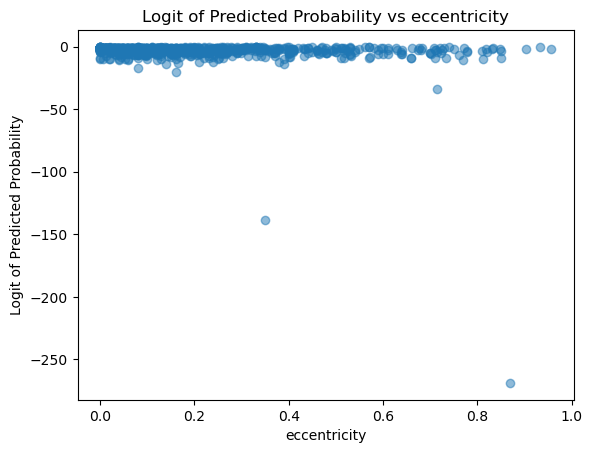

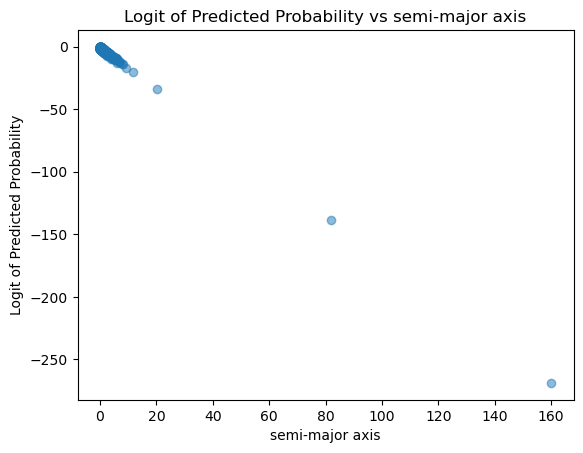

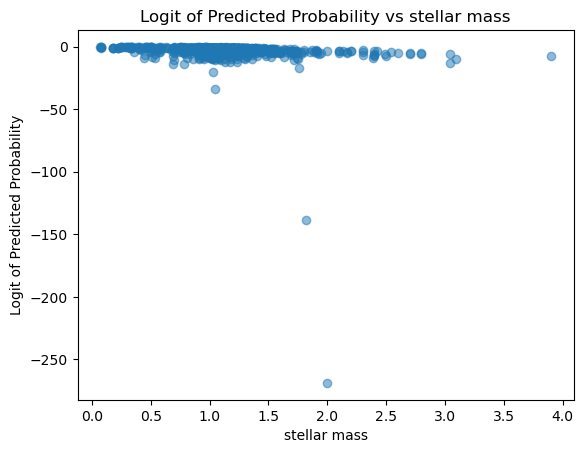

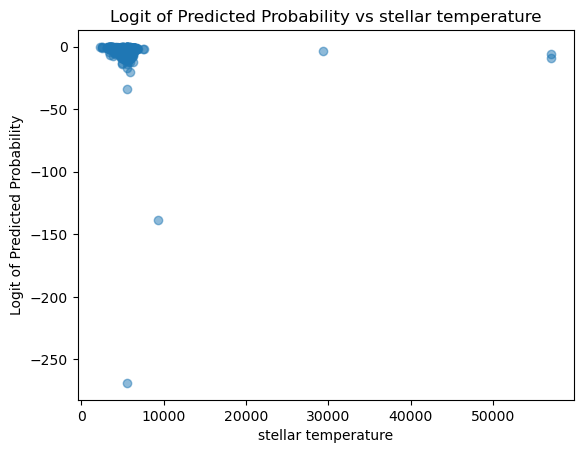

In [ ]:
#assessing the Linearity of Predictors with Log Odds
#The model assumes a linear relationship between the continuous predictors and the log-odds of the outcome
#This doesn’t mean that predictors must have a linear relationship with the outcome directly, but with the logit (log-odds) of the outcome

predictors = df[['eccentricity', 'semi-major axis', 'stellar mass', 'stellar temperature']]
target = df['orbital period']

df['orbital_period_encoded'] = df['orbital period'].astype('category').cat.codes

df['target'] = (df['orbital_period_encoded'] == 1).astype(int)

X = sm.add_constant(predictors)
y = df['target']

# Fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get predicted probabilities
pred_probs = log_reg.predict(X)
logit_preds = np.log(pred_probs / (1 - pred_probs))

# Plot each predictor against the logit of predicted probabilities
for predictor in predictors.columns:
    plt.figure()
    plt.scatter(df[predictor], logit_preds, alpha=0.5)
    plt.xlabel(predictor)
    plt.ylabel('Logit of Predicted Probability')
    plt.title(f'Logit of Predicted Probability vs {predictor}')
    plt.show()


### Data Transformation

In [210]:
#performing Winsorization to handle extreme outliers
df['eccentricity'] = winsorize(df['eccentricity'], limits=[0.05, 0.05])  # Trims 5% from each end
df['semi-major axis'] = winsorize(df['semi-major axis'], limits=[0.05, 0.05])
df['stellar mass'] = winsorize(df['stellar mass'], limits=[0.05, 0.05])
df['stellar temperature'] = winsorize(df['stellar temperature'], limits=[0.05, 0.05])


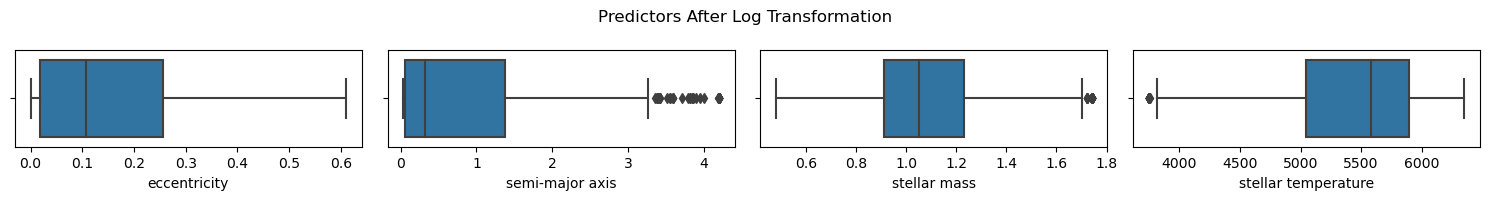

In [ ]:
#visualizing to see remaining outliers per predictor

plt.figure(figsize=(15, 2))

plt.subplot(1,4,1)
sns.boxplot(x=df["eccentricity"])

plt.subplot(1,4,2)
sns.boxplot(x=df["semi-major axis"])

plt.subplot(1,4,3)
sns.boxplot(x=df["stellar mass"])

plt.subplot(1,4,4)
sns.boxplot(x=df["stellar temperature"])

plt.suptitle("Predictors After Log Transformation")
plt.tight_layout()
plt.show()

In [ ]:
#applying Yeo-Johnson transformation after Winsorization to aid remaining outliers

pt = PowerTransformer(method='yeo-johnson')
df[['eccentricity', 'semi-major axis', 'stellar mass', 'stellar temperature']] = pt.fit_transform(df[['eccentricity', 'semi-major axis', 'stellar mass', 'stellar temperature']])

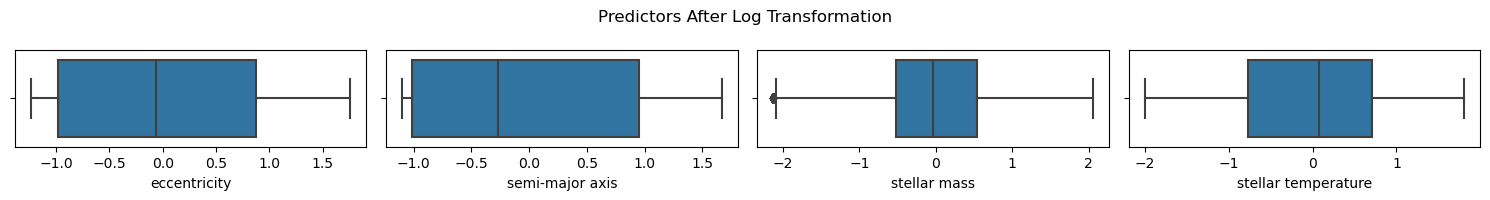

In [ ]:
# visualizing to check again the presence of any strong outliers

plt.figure(figsize=(15, 2))

plt.subplot(1,4,1)
sns.boxplot(x=df["eccentricity"])

plt.subplot(1,4,2)
sns.boxplot(x=df["semi-major axis"])

plt.subplot(1,4,3)
sns.boxplot(x=df["stellar mass"])

plt.subplot(1,4,4)
sns.boxplot(x=df["stellar temperature"])

plt.suptitle("Predictors After Log Transformation")
plt.tight_layout()
plt.show()

In [ ]:
#printing classes of orbital period to assess the class distribution of the target variable
class_distribution = df["orbital period"].value_counts()
print(class_distribution)

orbital period
long      449
short     369
medium    156
Name: count, dtype: int64


Optimization terminated successfully.
         Current function value: 0.401038
         Iterations 7


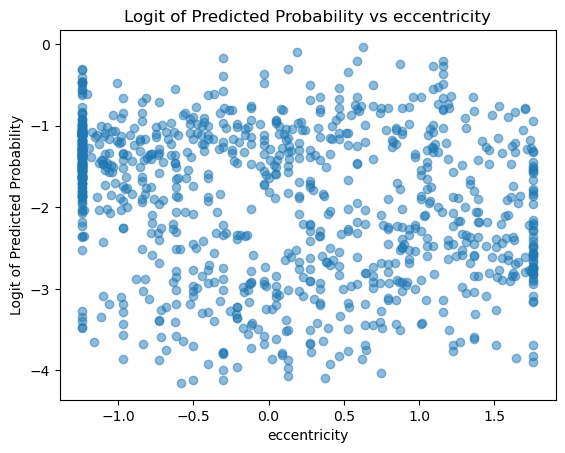

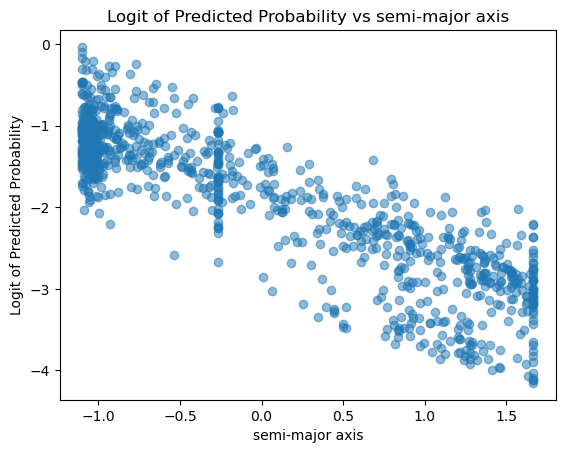

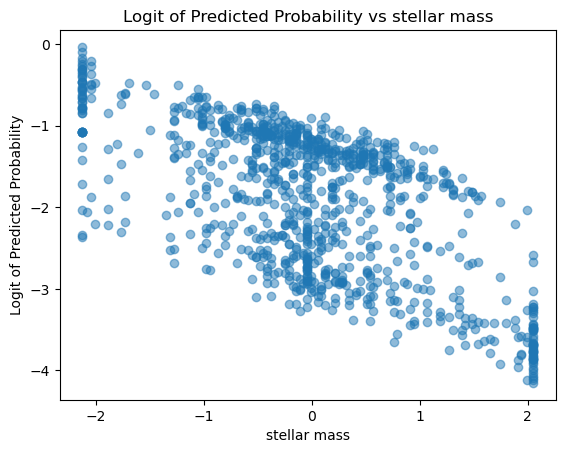

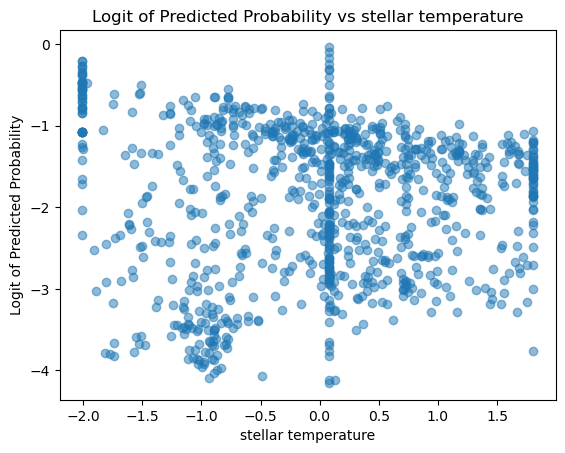

In [215]:
predictors = df[['eccentricity', 'semi-major axis', 'stellar mass', 'stellar temperature']]
target = df['orbital period']

df['orbital_period_encoded'] = df['orbital period'].astype('category').cat.codes

df['target'] = (df['orbital_period_encoded'] == 1).astype(int)

X = sm.add_constant(predictors)
y = df['target']

# Fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get predicted probabilities
pred_probs = log_reg.predict(X)
logit_preds = np.log(pred_probs / (1 - pred_probs))

# Plot each predictor against the logit of predicted probabilities
for predictor in predictors.columns:
    plt.figure()
    plt.scatter(df[predictor], logit_preds, alpha=0.5)
    plt.xlabel(predictor)
    plt.ylabel('Logit of Predicted Probability')
    plt.title(f'Logit of Predicted Probability vs {predictor}')
    plt.show()

In [ ]:
#checking to see if there are negative values to decide what tecnique to use in transforming the predictors
#this is important because there are transformation techniques that assume the values to be positive

print(df["eccentricity"].min())
print(df["stellar temperature"].min())

-1.2368114350868022
-2.0069909004837236


Optimization terminated successfully.
         Current function value: 0.437033
         Iterations 6


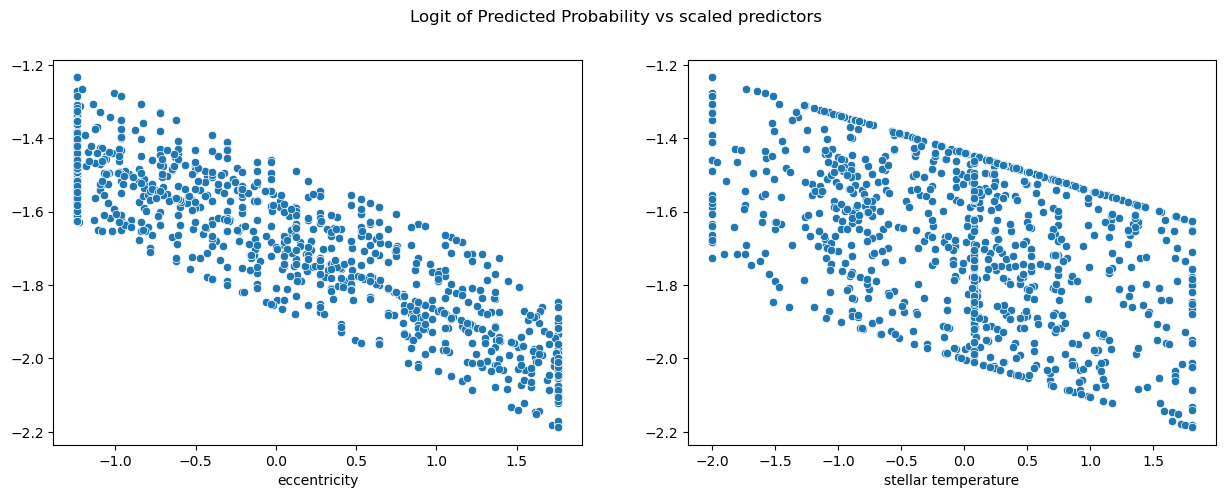

In [ ]:
#Standardization or Normalization (data scaling) will be used since there are present of negative values in the predictor columns
#scaling eccentricity and stellar temperature since they are the predictors that did not display any trend of linearity

predictors = df[['eccentricity', 'stellar temperature']]
target = df['orbital period']

scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)
predictors_scaled = df[["eccentricity", "stellar temperature"]]

df['orbital_period_encoded'] = df['orbital period'].astype('category').cat.codes
df['target'] = (df['orbital_period_encoded'] == 1).astype(int)

X = sm.add_constant(predictors)
y = df['target']

log_reg = sm.Logit(y, X).fit()

pred_probs = log_reg.predict(X)
logit_preds = np.log(pred_probs / (1 - pred_probs))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.scatterplot(x=df["eccentricity"], y=logit_preds)

plt.subplot(1,2,2)
sns.scatterplot(x=df["stellar temperature"], y=logit_preds)

plt.suptitle("Logit of Predicted Probability vs scaled predictors")
plt.show()


### Data processing

### Data modeling

### Hyperparameter tuning